<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

# Tabular Data Analysis with DataFrames.jl

[DataFrames.jl](http://juliadata.github.io/DataFrames.jl/stable/) is Julia's package for manipulating tabular data, like R's built-in or Python PanDas.

For this notebook, you will be using a pair of `.csv` files:
```
data/metadata.csv
data/features.csv
```

Each *metadata* CSV file contains basic data about cells found in a microscopy plate, during an experiment.

Each *features* CSV file contains additional measurements about the same cells performed by the software [TissueMAPS](http://www.tissuemaps.org).

We shell use DataFrame.jl to inspect the contents of these files and perform some statistics and plotting.

## Preamble

Before using DataFrames.jl, we must import it.  We shall also import package FileIO which provides convenient `load()` and `save()` functions.

In [1]:
using DataFrames
using FileIO

For basic statistics computation (mean, median, etc.) we need the following:

In [2]:
using Statistics

For plotting and plotting recipes of box and violin plots, the following are also needed:

In [3]:
using Plots
using StatsPlots

The rendering code does not realize we're using a (scrollable) web notebook and not a terminal, so we need to simulate having a large number of rows and columns to avoid that columns are omitted in displays:

In [4]:
ENV["COLUMNS"] = 1000;
ENV["LINES"] = 100;

## Load data

We can use FileIO's generic `load()` function to read a CSV file into a DataFrame: 

In [5]:
# "metadata" file for well D10
md = DataFrame(load("data/metadata.csv"));

In [6]:
# "feature values" for well D10
fv = DataFrame(load("data/features.csv"));

`DataFrame` objects display nicely in the notebook as tabular data: functions `head()` and `tail()` can be used to quickly glance at the data:

In [47]:
first(md, 3)

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,566404,p1,D07,0,0,0,0,1,1,0.0,0.0
2,566405,p1,D07,0,0,0,0,2,1,0.0,0.0
3,566406,p1,D07,0,0,0,0,3,1,0.0,0.0


Note that the first row of the CSV file was used to name the columns, not to provide actual data.

## Access table data

Function `size()` returns the lengths in the two dimensions of a  `DataFrame` object, just like it does for arrays:

In [8]:
size(md)

(22808, 11)

The above shows that our table has 22808 rows across 11 columns.  

**Note: *row index comes first!*** (This will be important when accessing data with numerical indices below.)

### Read entire columns

There are a few ways to get an *entire column* out of the table, by using variants on array-get `[]` notation:

1. As an array *view*, with `df.column_name` (note this does not copy the array):

In [9]:
labels = md.label;

In [10]:
labels[1:5] # print first 5 label values

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

2. As an array, with `df[:, column_index]` (copy) or `df[:, column_index]` (view like above):

In [11]:
labels = md[:, :label];

In [12]:
labels[1:5] # print first 5 label values

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

3. As another DataFrame, with `df[:, [:column_name]]` (copy) or `df[!, [:column_name]]` (view):

In [13]:
labels_df = md[!, [:label]];

In [14]:
first(labels_df, 5)

,label
,Int64
1,1
2,2
3,3
4,4
5,5


Columns extracted as array copies or array views support (of course!) all normal array operations on them:

In [15]:
length(labels)

22808

In [16]:
unique_labels = unique(labels);

In [17]:
length(unique_labels)

1178

### Read entire rows

A single row can be accessed using the usual 2D-array access syntax:

In [18]:
row2 = md[2, :]

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
2,566405,p1,D07,0,0,0,0,2,1,0.0,0.0


Note that the extracted row, although similar to a DataFrame when shown, is a different object:

In [19]:
typeof(row2)

DataFrameRow{DataFrame,DataFrames.Index}

We can then fetch individual values by column name (symbol) or index:

In [20]:
row2[:well_name]

"D07"

In [21]:
row2[2]

"p1"

## Quick computation of basic statistical quantities

A `DataFrame`'s `describe()` method provides a quick statistical summary of the data (but only for *continuous* variables):

In [22]:
stat = describe(fv[!, [:Intensity_mean_A01_C03]])

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,Intensity_mean_A01_C03,178.423,103.0,181.375,824.712,,,Float64


Note that the value returned by `describe()` is again a DataFrame, so getting out a single value can be a bit combersome:

In [23]:
stat[1,:][:mean]

178.42255450758506

You can compute the very same values (and many others!) by directly applying a function to an array view of column:

In [24]:
using Statistics

In [25]:
# compute the median
median(fv[!, :Intensity_mean_A01_C03])

181.37462549999998

In [26]:
# compute the average of the log intensity
mean(log.(fv[!, :Intensity_mean_A01_C03]))

5.168034971225998

-----

## Exercise 5.A

What is the mean value of column `Intensity_mean_A01_C03`?

In [27]:
# your solution here

## Exercise 5.B

How many unique values are in column `TPlus` in the metadata?

In [28]:
# your solution here

## Exercise 5.C.

The `is_border` column in the "metadata" table tells you whether a cell lies at the border of an acquisition site or not (1 = lies at the border, 0 = does not touch nor cross the border).

Can you count the number of "border" cells?

In [29]:
# your solution here

-----

## Join tabular data

There are two ways of joining tables:

- We may want to "stack" one table on top of another (only possible if the tables have the same columns), or "adjoin" two tables having the same number of rows; like we do with arrays, this is accomplished with functions `vcat()` and `hcat()`

- We may want to form a new table by "joining" rows that have some value (called a *key*) in common; this is accomplished by a `DataFrame`'s `join()` function.

### "Stacking" tables

Stacking tables is accomplished with function `vcat()`, which takes as arguments the tables to stack.

In [30]:
double_md = vcat(md, md);

In [31]:
size(double_md)

(45616, 11)

In [32]:
size(double_md, 1) == 2*size(md, 1)

true

When "adjoining" tables, it can occur that the two DataFrames have some column names in common; an additional parameter `makeunique=true` allows Julia to rename duplicate columns:

In [33]:
double_md  = hcat(md, md, makeunique=true);

In [48]:
first(double_md, 3)

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus,mapobject_id_1,plate_name_1,well_name_1,well_pos_y_1,well_pos_x_1,tpoint_1,zplane_1,label_1,is_border_1,Classification-5_1,TPlus_1
,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,566404,p1,D07,0,0,0,0,1,1,0.0,0.0,566404,p1,D07,0,0,0,0,1,1,0.0,0.0
2,566405,p1,D07,0,0,0,0,2,1,0.0,0.0,566405,p1,D07,0,0,0,0,2,1,0.0,0.0
3,566406,p1,D07,0,0,0,0,3,1,0.0,0.0,566406,p1,D07,0,0,0,0,3,1,0.0,0.0


### Joining by rows

The `join()` function allows making a new table out of two existing tables with a set of common columns.  The syntax is as follows:
```
new_table = join(table1, table2, on=[pairs of corresponding columns], kind=...)
```

For example:

In [35]:
merged = join(md, fv, on=[:mapobject_id], kind=:inner);

In [49]:
first(merged, 3)

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus,Nuclei_Intensity_max_A02_C01,Nuclei_Intensity_mean_A02_C01,Nuclei_Intensity_min_A02_C01,Nuclei_Intensity_sum_A02_C01,Nuclei_Intensity_std_A02_C01,Intensity_max_A01_C02,Intensity_mean_A01_C02,Intensity_min_A01_C02,Intensity_sum_A01_C02,Intensity_std_A01_C02,Intensity_max_A01_C03,Intensity_mean_A01_C03,Intensity_min_A01_C03,Intensity_sum_A01_C03,Intensity_std_A01_C03,Intensity_max_A02_C04,Intensity_mean_A02_C04,Intensity_min_A02_C04,Intensity_sum_A02_C04,Intensity_std_A02_C04,Nuclei_Morphology_Area,Nuclei_Morphology_Eccentricity,Nuclei_Morphology_Convexity,Nuclei_Morphology_Circularity,Nuclei_Morphology_Perimeter,Nuclei_Morphology_Elongation,Morphology_Area,Morphology_Eccentricity,Morphology_Convexity,Morphology_Circularity,Morphology_Perimeter,Morphology_Elongation,Texture_Gabor-frequency-1_A01_C03,Texture_Gabor-frequency-10_A01_C03
,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64⍰,Float64,Float64⍰,Float64,Float64,Float64,Float64⍰,Float64,Float64⍰,Float64,Float64
1,566404,p1,D07,0,0,0,0,1,1,0.0,0.0,452.0,267.323,123.0,393499.0,69.2942,9049.0,3730.61,388.0,1.31877e7,2137.32,410.0,181.701,104.0,642312.0,32.6813,137.0,110.339,94.0,390047.0,6.19284,1472.0,0.349673,0.947233,0.691631,163.539,0.063128,3535.0,0.486365,0.853246,0.562839,280.936,0.126244,14515.4,1396.28
2,566405,p1,D07,0,0,0,0,2,1,0.0,0.0,466.0,196.026,122.0,394013.0,44.987,7614.0,2970.23,252.0,1.21928e7,2056.35,353.0,181.789,103.0,746245.0,58.8372,144.0,108.509,92.0,445429.0,4.42207,2010.0,0.544756,0.936626,0.623132,201.332,0.161406,4105.0,0.896143,0.867681,0.468666,331.765,0.556235,37456.1,1407.19
3,566406,p1,D07,0,0,0,0,3,1,0.0,0.0,437.0,188.11,122.0,540629.0,32.8141,8110.0,2727.28,255.0,2.22328e7,2276.91,323.0,163.918,96.0,1.33626e6,55.3932,166.0,108.45,89.0,884082.0,8.40256,2874.0,0.738973,0.977884,0.70543,226.267,0.326265,8152.0,0.57924,0.883494,0.541058,435.126,0.184843,32084.6,772.151


Parameter *kind* has a few possible values; the most used are:

* `:inner`: merge rows where both tables agree on the value of the common columns;
* `:outer`: take _all_ rows, fill in null values when row of one table cannot be matched.
* `:cross`: full Cartesian product: all combinations of rows are taken.

If you know databases, this is exactly the same semantics of [SQL's JOIN keyword](https://www.w3schools.com/sql/sql_join.asp)

Parameter *on* takes one of the following forms:

- Vector of pairs, e.g., `[:id=>:mapobject_id, :is_border=>:is_border]`; left of `=>` are the column names in the left table, right of `=>` are column names in the other one.
- Vector of column names, e.g., `[:id,:well_name]` if columns to be joined have the same name in both tables.
- A single pair or a single column name, if joining on a single column.

## Make sub-tables

The `view()` operator can be used to create views on sub-tables, by specifying the rows and columns to extract:
```
sub = view(df, rows, columns)
```
here `rows` and `columns` can be a vector of any of the following:

- a scalar row/column number or column names (e.g., `:id`), 
- a *ranges* (e.g., `1:10`),
- a **selector** (which we'll explain in a while)

For example:

In [37]:
view(md, [1,3,5,7], [:well_name, :label, :is_border])

,well_name,label,is_border
,String,Int64,Int64
1,D07,1,1
2,D07,3,1
3,D07,5,1
4,D07,7,1


**Note:** the `view()` function does *not copy* the table data -- so any modification to the sub-table will be reflected on the parent table.  Use `copy(view())` to create an independent sub-table.

## Selectors

Selectors are logical expressions on a column (or row) of a table.  Technically, they are boolean vectors with the same number of elements as there are rows in the DataFrame.

In [38]:
# select all objects with numerical label 42
label42 = (md[!, :label] .== 42);

In [39]:
# select all objects whose mean intensity in the DAPI channel is over 1 sigma from the avg 
dapi_plus1s = (fv[!, :Nuclei_Intensity_mean_A02_C01] .> 259.69);

You can use selectors to extract a sub-table out of an existing one.

In [40]:
# only data about cell labeled 42
table_only_label42 = md[label42, :];

In [41]:
size(table_only_label42, 1)

25

In [51]:
first(table_only_label42, 3)

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,Classification-5,TPlus
,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,566445,p1,D07,0,0,0,0,42,0,1.0,1.0
2,486658,p1,D07,0,1,0,0,42,0,0.0,0.0
3,538967,p1,D07,0,2,0,0,42,0,0.0,0.0


-----

## Exercise 5.D

Make a single large table `all` by joining tables `md` and `fv` over the common column `mapobject_id`.

How many rows are in the combined table?

In [43]:
# your solution here

## Exercise 5.E

Make a table `good` by extracting from `all` only rows which refer to objects that are *not* "border" objects.

How many good objects are there?  

In [44]:
# your solution

## Exercise 5.F

Make two tables `md0` and `md1` by splitting on the two values of column `TPlus` (`0` or `1`).
What is the mean of column `Intensity_mean_A01_C03` in each table?  And the std deviation?

In [45]:
# your solution

-----

# Plotting

Package `StatsPlots` provides additional recipes for statistical plots; in particular, box plots and violin plots.

## Box plots

The `boxplot(xs,ys)` function requires that `ys` is a numerical vector, and `xs` is an array of "labels" for values in `ys`: elements in `ys` corresponding to the same label in `xs` will be plotted on a vertical line, and the features of the box calculated from them.  There are unfortunately, little customization options.

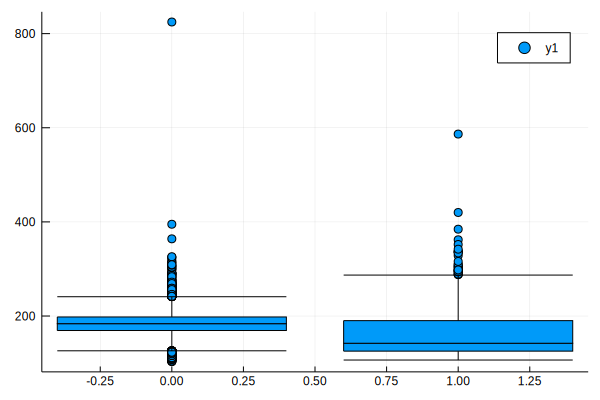

In [46]:
using StatsPlots

xs = merged[!, :TPlus];
ys = merged[!, :Intensity_mean_A01_C03]
boxplot(xs, ys)